In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import pickle
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# Create output directories
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/reports', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [2]:
# Load data from Step 3
df = pd.read_csv('D:\My projects\customer_segmentation_project\data\processed\step3_features_engineered.csv')

print(f"✓ Data loaded successfully")
print(f"  Shape: {df.shape[0]:,} customers, {df.shape[1]} features")
print(f"\nFirst 5 rows:")
df.head()

✓ Data loaded successfully
  Shape: 2,229 customers, 64 features

First 5 rows:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Campaign_Acceptance_Rate,Has_Complained,Engagement_Score,CLV_Estimate,Customer_Value_Score,Is_High_Spender,Is_Active,Is_Campaign_Responder,Is_Web_Shopper,Is_Deal_Seeker
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0.166667,0,28.4,2824.212329,83.333333,1,1,1,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0.000000,0,7.0,23.142857,25.000000,0,1,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0.000000,0,21.8,740.727273,75.000000,0,1,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0.000000,0,9.2,47.111111,33.333333,0,1,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0.000000,0,20.0,400.900000,41.666667,0,0,0,0,0


In [3]:
#  Select Optimized Features for Clustering

features_for_clustering = [
    # RFM Metrics (3)
    'R_Score', 'F_Score', 'M_Score',
    
    # Demographics (5)
    'Age', 'Income', 'Education_Level', 'Family_Size', 'Has_Children',
    
    # Spending Behavior (3)
    'Avg_Order_Value', 'Purchase_Frequency_Rate', 'Customer_Tenure_Days',
    
    # Product Preferences (4)
    'Wine_Ratio', 'Meat_Ratio', 'Product_Diversity', 'Premium_Product_Ratio',
    
    # Channel Preferences (2)
    'Web_Purchase_Ratio', 'Store_Purchase_Ratio',
    
    # Engagement (4)
    'Campaign_Acceptance_Rate', 'NumWebVisitsMonth', 'Has_Complained', 'Engagement_Score',
    
    # Value Metrics (2)
    'CLV_Estimate', 'Customer_Value_Score',
    
    # Binary Flags (5)
    'Is_High_Spender', 'Is_Active', 'Is_Campaign_Responder', 
    'Is_Web_Shopper', 'Is_Deal_Seeker'
]

print("\n📊 Using OPTIMIZED feature set:")
print(f"  • Total features: {len(features_for_clustering)}")
print(f"  • No redundancy")
print(f"  • Expected: Faster clustering & better results")

# Filter to columns that exist
features_for_clustering = [f for f in features_for_clustering if f in df.columns]

print(f"\n✓ Verified: {len(features_for_clustering)} features available")
print(f"\nSelected features:")
for i, feat in enumerate(features_for_clustering, 1):
    print(f"  {i:2d}. {feat}")

# Create feature matrix
X = df[features_for_clustering].copy()

# Handle missing values
missing_before = X.isnull().sum().sum()
X = X.fillna(X.median())
missing_after = X.isnull().sum().sum()

print(f"\nFeature matrix prepared:")
print(f"  Shape: {X.shape}")
print(f"  Missing values before: {missing_before}")
print(f"  Missing values after: {missing_after}")



📊 Using OPTIMIZED feature set:
  • Total features: 28
  • No redundancy
  • Expected: Faster clustering & better results

✓ Verified: 28 features available

Selected features:
   1. R_Score
   2. F_Score
   3. M_Score
   4. Age
   5. Income
   6. Education_Level
   7. Family_Size
   8. Has_Children
   9. Avg_Order_Value
  10. Purchase_Frequency_Rate
  11. Customer_Tenure_Days
  12. Wine_Ratio
  13. Meat_Ratio
  14. Product_Diversity
  15. Premium_Product_Ratio
  16. Web_Purchase_Ratio
  17. Store_Purchase_Ratio
  18. Campaign_Acceptance_Rate
  19. NumWebVisitsMonth
  20. Has_Complained
  21. Engagement_Score
  22. CLV_Estimate
  23. Customer_Value_Score
  24. Is_High_Spender
  25. Is_Active
  26. Is_Campaign_Responder
  27. Is_Web_Shopper
  28. Is_Deal_Seeker

Feature matrix prepared:
  Shape: (2229, 28)
  Missing values before: 0
  Missing values after: 0


In [5]:
## ⚖️ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nBefore scaling - Sample statistics:")
print(X[['Income', 'Age', 'CLV_Estimate']].describe().loc[['mean', 'std']].round(2))

# Convert scaled data to DataFrame for display
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
print("\nAfter scaling - Sample statistics:")
print(X_scaled_df[['Income', 'Age', 'CLV_Estimate']].describe().loc[['mean', 'std']].round(2))

# Save scaler for later use
with open('D://My projects/customer_segmentation_project/notebooks/outputs/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\n✓ Scaler saved to: outputs/models/scaler.pkl")

print(f"\nScaling verification:")
print(f"  Mean: ~{X_scaled.mean():.2e} (should be close to 0)")
print(f"  Std: ~{X_scaled.std():.2f} (should be close to 1)")




Before scaling - Sample statistics:
        Income    Age  CLV_Estimate
mean  51619.50  55.11        730.25
std   20601.22  11.71        791.95

After scaling - Sample statistics:
      Income  Age  CLV_Estimate
mean     0.0  0.0           0.0
std      1.0  1.0           1.0

✓ Scaler saved to: outputs/models/scaler.pkl

Scaling verification:
  Mean: ~1.46e-17 (should be close to 0)
  Std: ~1.00 (should be close to 1)



Calculating WCSS and Silhouette scores for k=2 to 10...
  k=2: WCSS=49,351, Silhouette=0.2096
  k=3: WCSS=44,795, Silhouette=0.1576
  k=4: WCSS=42,378, Silhouette=0.1272
  k=5: WCSS=39,846, Silhouette=0.1321
  k=6: WCSS=37,811, Silhouette=0.1385
  k=7: WCSS=36,325, Silhouette=0.1323
  k=8: WCSS=34,701, Silhouette=0.1356
  k=9: WCSS=33,025, Silhouette=0.1370
  k=10: WCSS=31,788, Silhouette=0.1418


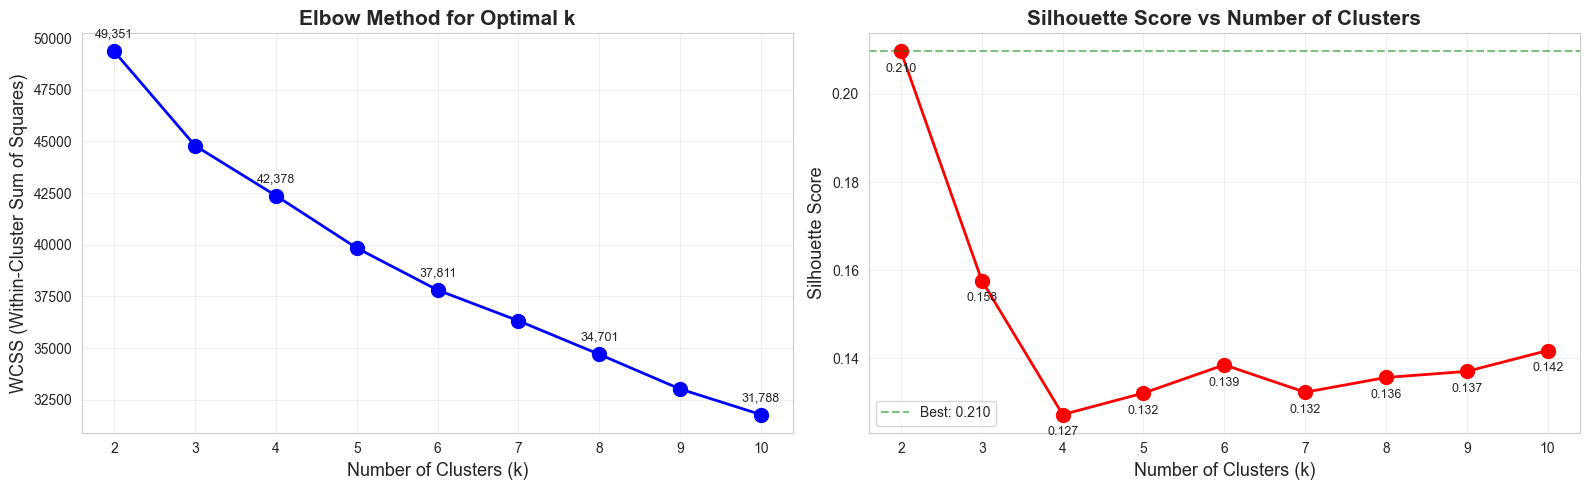


✓ Elbow curve saved to: outputs/figures/step4_elbow_method.png

🎯 Optimal k based on Silhouette Score: 2
   Best Silhouette Score: 0.2096
   ⚠ Reasonable cluster separation


In [6]:
## 📊 Finding Optimal Number of Clusters
print("\nCalculating WCSS and Silhouette scores for k=2 to 10...")

wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: WCSS={kmeans.inertia_:,.0f}, Silhouette={sil_score:.4f}")

# Plot Elbow Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# WCSS plot (Elbow)
axes[0].plot(k_range, wcss, 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=13)
axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=13)
axes[0].set_title('Elbow Method for Optimal k', fontsize=15, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Add annotations
for i, (k, w) in enumerate(zip(k_range, wcss)):
    if i % 2 == 0:  # Annotate every other point
        axes[0].annotate(f'{w:,.0f}', (k, w), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=9)

# Silhouette score plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=13)
axes[1].set_ylabel('Silhouette Score', fontsize=13)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=15, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=max(silhouette_scores), color='g', linestyle='--', 
               alpha=0.5, label=f'Best: {max(silhouette_scores):.3f}')
axes[1].legend()

# Add annotations
for k, s in zip(k_range, silhouette_scores):
    axes[1].annotate(f'{s:.3f}', (k, s), textcoords="offset points", 
                    xytext=(0,-15), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/figures/step4_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Elbow curve saved to: outputs/figures/step4_elbow_method.png")

# Determine optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Optimal k based on Silhouette Score: {optimal_k}")
print(f"   Best Silhouette Score: {max(silhouette_scores):.4f}")

# Interpretation
if max(silhouette_scores) > 0.5:
    print(f"   ✓ Excellent cluster separation!")
elif max(silhouette_scores) > 0.3:
    print(f"   ✓ Good cluster separation")
elif max(silhouette_scores) > 0.2:
    print(f"   ⚠ Reasonable cluster separation")
else:
    print(f"   ⚠ Weak cluster separation - consider fewer clusters")



Applying K-Means with k=2...
✓ K-Means model saved to: outputs/models/kmeans_model.pkl

K-Means Cluster Distribution:
  Cluster 0: 963 customers (43.2%)
  Cluster 1: 1,266 customers (56.8%)

📊 K-Means Evaluation Metrics:
  • Silhouette Score: 0.2096 (higher is better, range: -1 to 1)
  • Davies-Bouldin Index: 1.8083 (lower is better)
  • Calinski-Harabasz Score: 589.38 (higher is better)


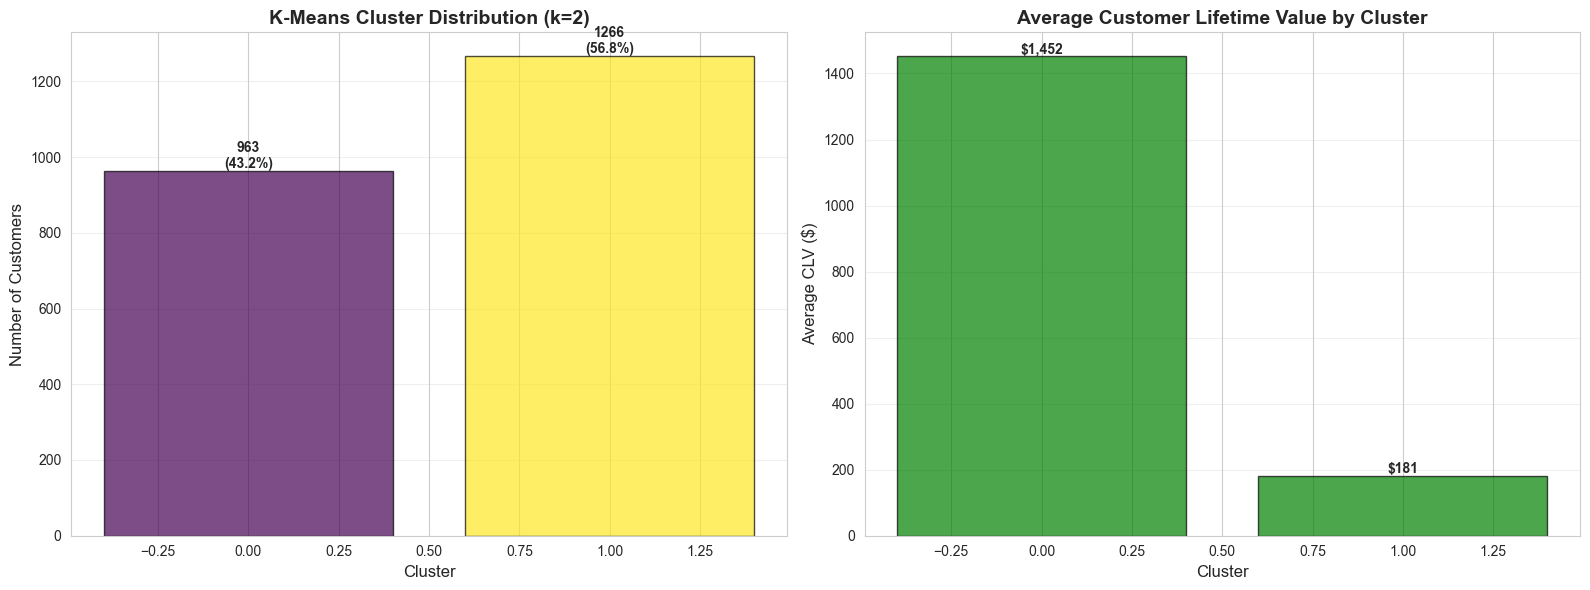


✓ K-Means visualization saved to: outputs/figures/step4_kmeans_results.png


In [7]:
## 🎯 K-Means Clustering
print(f"\nApplying K-Means with k={optimal_k}...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Save model
with open('D://My projects/customer_segmentation_project/notebooks/outputs/models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
print("✓ K-Means model saved to: outputs/models/kmeans_model.pkl")

print(f"\nK-Means Cluster Distribution:")
cluster_counts = df['KMeans_Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = (count / len(df) * 100)
    print(f"  Cluster {cluster}: {count:,} customers ({pct:.1f}%)")

# Calculate evaluation metrics
kmeans_silhouette = silhouette_score(X_scaled, df['KMeans_Cluster'])
kmeans_db = davies_bouldin_score(X_scaled, df['KMeans_Cluster'])
kmeans_ch = calinski_harabasz_score(X_scaled, df['KMeans_Cluster'])

print(f"\n📊 K-Means Evaluation Metrics:")
print(f"  • Silhouette Score: {kmeans_silhouette:.4f} (higher is better, range: -1 to 1)")
print(f"  • Davies-Bouldin Index: {kmeans_db:.4f} (lower is better)")
print(f"  • Calinski-Harabasz Score: {kmeans_ch:.2f} (higher is better)")

# Visualize K-Means results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster size distribution
colors_cluster = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))
axes[0].bar(cluster_counts.index, cluster_counts.values, 
           color=colors_cluster, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_title(f'K-Means Cluster Distribution (k={optimal_k})', 
                 fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, v in enumerate(cluster_counts.values):
    axes[0].text(cluster_counts.index[i], v, f'{v}\n({v/len(df)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Average CLV by cluster
if 'CLV_Estimate' in df.columns:
    avg_clv = df.groupby('KMeans_Cluster')['CLV_Estimate'].mean().sort_index()
    axes[1].bar(avg_clv.index, avg_clv.values, color='green', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Cluster', fontsize=12)
    axes[1].set_ylabel('Average CLV ($)', fontsize=12)
    axes[1].set_title('Average Customer Lifetime Value by Cluster', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(avg_clv.values):
        axes[1].text(avg_clv.index[i], v, f'${v:,.0f}', 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/notebooks/outputs/figures/step4_kmeans_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ K-Means visualization saved to: outputs/figures/step4_kmeans_results.png")


Creating dendrogram with 500 samples...


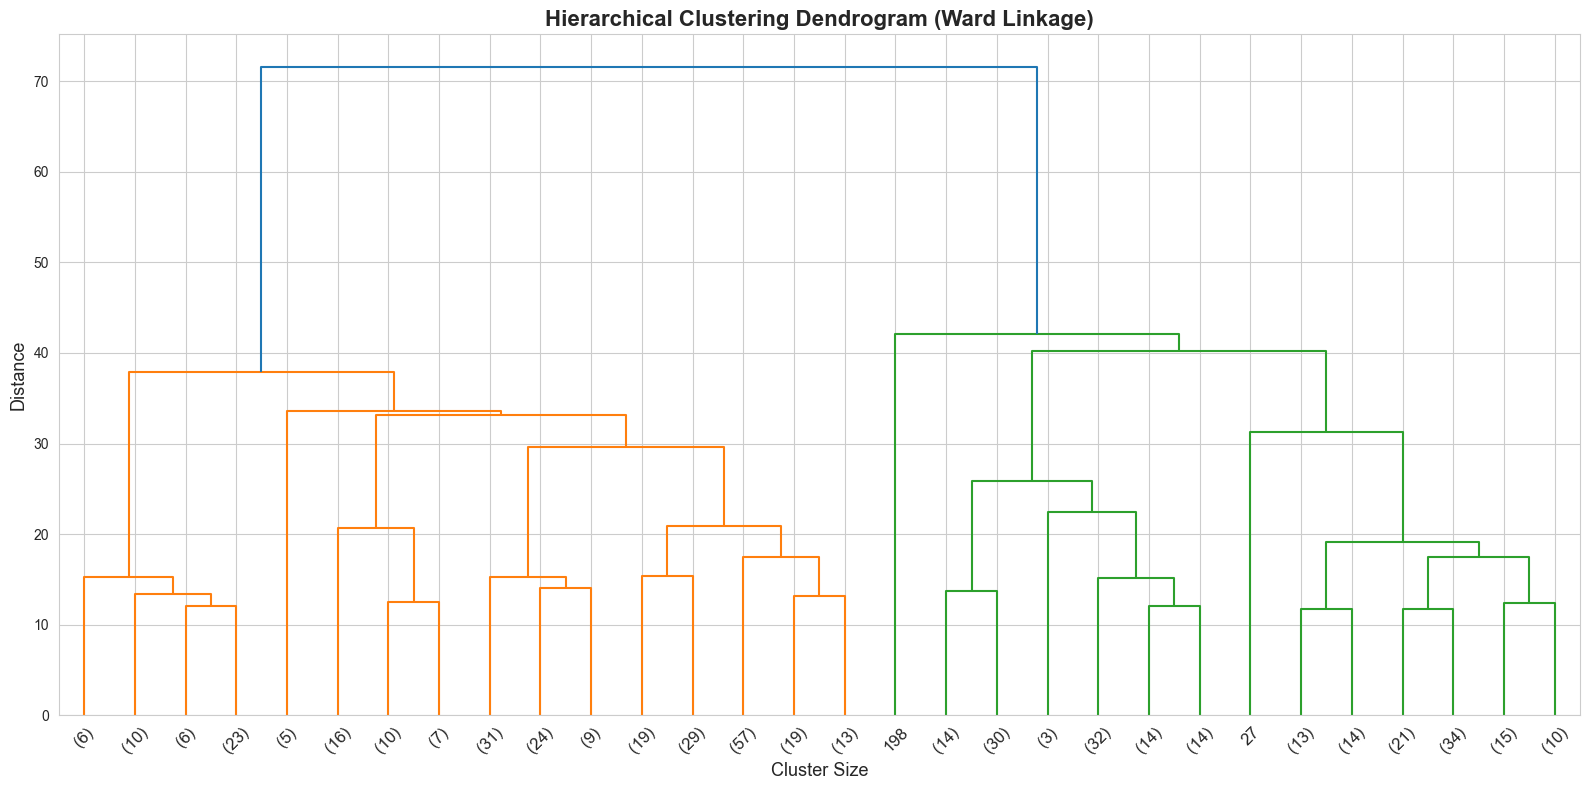

✓ Dendrogram saved to: outputs/figures/step4_dendrogram.png

Applying Hierarchical Clustering with 2 clusters...

Hierarchical Cluster Distribution:
  Cluster 0: 1,576 customers (70.7%)
  Cluster 1: 653 customers (29.3%)

📊 Hierarchical Clustering Evaluation Metrics:
  • Silhouette Score: 0.2104
  • Davies-Bouldin Index: 1.7772
  • Calinski-Harabasz Score: 508.22


In [8]:
## 🌳 Hierarchical Clustering
sample_size = min(500, len(X_scaled))
print(f"\nCreating dendrogram with {sample_size} samples...")

X_sample = X_scaled[:sample_size]
linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, 
           truncate_mode='lastp',
           p=30,
           show_leaf_counts=True,
           leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Cluster Size', fontsize=13)
plt.ylabel('Distance', fontsize=13)
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/notebooks/outputs/figures/step4_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dendrogram saved to: outputs/figures/step4_dendrogram.png")

# Apply hierarchical clustering to full dataset
print(f"\nApplying Hierarchical Clustering with {optimal_k} clusters...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)

print(f"\nHierarchical Cluster Distribution:")
hier_counts = df['Hierarchical_Cluster'].value_counts().sort_index()
for cluster, count in hier_counts.items():
    pct = (count / len(df) * 100)
    print(f"  Cluster {cluster}: {count:,} customers ({pct:.1f}%)")

# Evaluation metrics
hier_silhouette = silhouette_score(X_scaled, df['Hierarchical_Cluster'])
hier_db = davies_bouldin_score(X_scaled, df['Hierarchical_Cluster'])
hier_ch = calinski_harabasz_score(X_scaled, df['Hierarchical_Cluster'])

print(f"\n📊 Hierarchical Clustering Evaluation Metrics:")
print(f"  • Silhouette Score: {hier_silhouette:.4f}")
print(f"  • Davies-Bouldin Index: {hier_db:.4f}")
print(f"  • Calinski-Harabasz Score: {hier_ch:.2f}")


Finding optimal epsilon (eps) parameter...


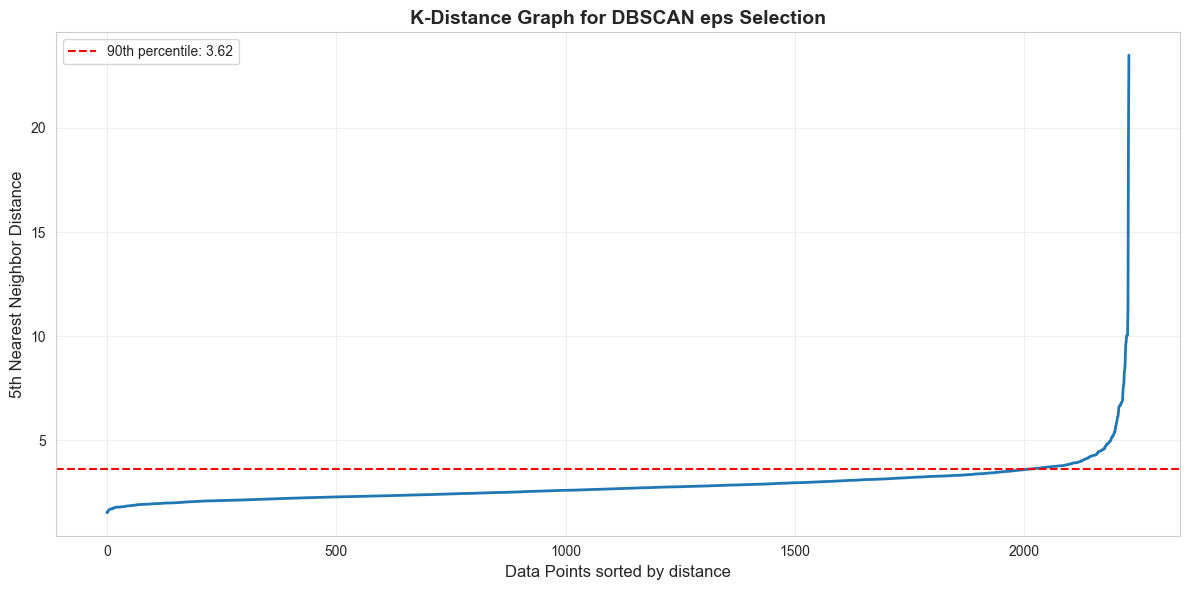

✓ K-distance graph saved to: outputs/figures/step4_k_distance_graph.png

Applying DBSCAN with eps=3.6151, min_samples=5...

DBSCAN Cluster Distribution:
  Noise points: 114 (5.1%)
  Cluster 0: 1,796 customers (80.6%)
  Cluster 1: 125 customers (5.6%)
  Cluster 2: 152 customers (6.8%)
  Cluster 3: 31 customers (1.4%)
  Cluster 4: 11 customers (0.5%)

📊 DBSCAN Results:
  • Number of clusters: 5
  • Noise points: 114 (5.11%)

📊 DBSCAN Evaluation Metrics (excluding noise):
  • Silhouette Score: 0.0483
  • Davies-Bouldin Index: 1.7790
  • Calinski-Harabasz Score: 70.65


In [9]:
## 🔍 DBSCAN Clustering
print("\nFinding optimal epsilon (eps) parameter...")
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Data Points sorted by distance', fontsize=12)
plt.ylabel('5th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph for DBSCAN eps Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=np.percentile(distances, 90), color='r', linestyle='--', 
           label=f'90th percentile: {np.percentile(distances, 90):.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/notebooks/outputs/figures/step4_k_distance_graph.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ K-distance graph saved to: outputs/figures/step4_k_distance_graph.png")

# Apply DBSCAN
eps_value = np.percentile(distances, 90)
print(f"\nApplying DBSCAN with eps={eps_value:.4f}, min_samples=5...")

dbscan = DBSCAN(eps=eps_value, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

print(f"\nDBSCAN Cluster Distribution:")
dbscan_counts = df['DBSCAN_Cluster'].value_counts().sort_index()
for cluster, count in dbscan_counts.items():
    pct = (count / len(df) * 100)
    if cluster == -1:
        print(f"  Noise points: {count:,} ({pct:.1f}%)")
    else:
        print(f"  Cluster {cluster}: {count:,} customers ({pct:.1f}%)")

n_clusters_dbscan = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'].values else 0)
n_noise = list(df['DBSCAN_Cluster'].values).count(-1)

print(f"\n📊 DBSCAN Results:")
print(f"  • Number of clusters: {n_clusters_dbscan}")
print(f"  • Noise points: {n_noise} ({n_noise/len(df)*100:.2f}%)")

# Evaluation metrics (excluding noise)
if n_clusters_dbscan > 1 and n_noise < len(df):
    mask = df['DBSCAN_Cluster'] != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(X_scaled[mask], df.loc[mask, 'DBSCAN_Cluster'])
        dbscan_db = davies_bouldin_score(X_scaled[mask], df.loc[mask, 'DBSCAN_Cluster'])
        dbscan_ch = calinski_harabasz_score(X_scaled[mask], df.loc[mask, 'DBSCAN_Cluster'])
        
        print(f"\n📊 DBSCAN Evaluation Metrics (excluding noise):")
        print(f"  • Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"  • Davies-Bouldin Index: {dbscan_db:.4f}")
        print(f"  • Calinski-Harabasz Score: {dbscan_ch:.2f}")
    else:
        dbscan_silhouette = dbscan_db = dbscan_ch = np.nan
else:
    print("\n⚠ DBSCAN found too few clusters or too many noise points for evaluation")
    dbscan_silhouette = dbscan_db = dbscan_ch = np.nan


📊 Algorithm Performance Comparison:
   Algorithm  N_Clusters  Silhouette_Score  Davies_Bouldin  Calinski_Harabasz
     K-Means           2          0.209629        1.808328         589.378377
Hierarchical           2          0.210373        1.777191         508.219395
      DBSCAN           5          0.048270        1.778952          70.649597

✓ Comparison saved to: outputs/reports/step4_algorithm_comparison.csv


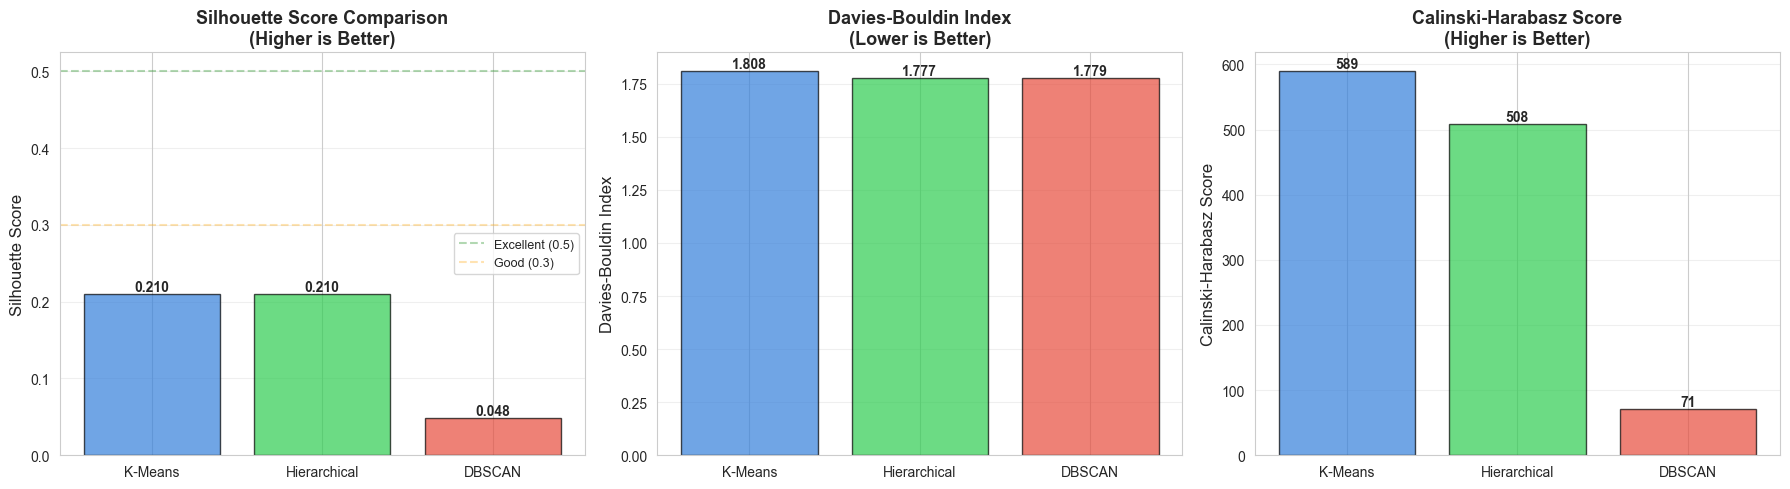


✓ Comparison visualization saved to: outputs/figures/step4_algorithm_comparison.png

🏆 Best Performing Algorithm: Hierarchical
   Silhouette Score: 0.2104
   Reason: Highest silhouette score among all algorithms
   ✓ Final_ML_Cluster column created using Hierarchical


In [10]:
## ⚖️ Comparing Clustering Algorithms
comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'N_Clusters': [optimal_k, optimal_k, n_clusters_dbscan],
    'Silhouette_Score': [kmeans_silhouette, hier_silhouette, dbscan_silhouette],
    'Davies_Bouldin': [kmeans_db, hier_db, dbscan_db],
    'Calinski_Harabasz': [kmeans_ch, hier_ch, dbscan_ch]
})

print("\n📊 Algorithm Performance Comparison:")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('D://My projects/customer_segmentation_project/notebooks/outputs/reports/step4_algorithm_comparison.csv', index=False)
print("\n✓ Comparison saved to: outputs/reports/step4_algorithm_comparison.csv")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algorithms = comparison_df['Algorithm']
colors_algo = ["#347fdb", "#2ecc50", '#e74c3c']

# Silhouette scores
axes[0].bar(algorithms, comparison_df['Silhouette_Score'], color=colors_algo, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score Comparison\n(Higher is Better)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0.5, color='green', linestyle='--', alpha=0.3, label='Excellent (0.5)')
axes[0].axhline(y=0.3, color='orange', linestyle='--', alpha=0.3, label='Good (0.3)')
axes[0].legend(fontsize=9)
for i, v in enumerate(comparison_df['Silhouette_Score']):
    if not np.isnan(v):
        axes[0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin Index
axes[1].bar(algorithms, comparison_df['Davies_Bouldin'], color=colors_algo, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Davies_Bouldin']):
    if not np.isnan(v):
        axes[1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Calinski-Harabasz Score
axes[2].bar(algorithms, comparison_df['Calinski_Harabasz'], color=colors_algo, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[2].set_title('Calinski-Harabasz Score\n(Higher is Better)', fontsize=13, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Calinski_Harabasz']):
    if not np.isnan(v):
        axes[2].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/notebooks/outputs/figures/step4_algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualization saved to: outputs/figures/step4_algorithm_comparison.png")

# Determine best algorithm
valid_scores = comparison_df[comparison_df['Silhouette_Score'].notna()]
if len(valid_scores) > 0:
    best_algo = valid_scores.loc[valid_scores['Silhouette_Score'].idxmax(), 'Algorithm']
    best_score = valid_scores['Silhouette_Score'].max()
    
    print(f"\n🏆 Best Performing Algorithm: {best_algo}")
    print(f"   Silhouette Score: {best_score:.4f}")
    print(f"   Reason: Highest silhouette score among all algorithms")
    
    # Set final cluster column
    if best_algo == 'K-Means':
        df['Final_ML_Cluster'] = df['KMeans_Cluster']
    elif best_algo == 'Hierarchical':
        df['Final_ML_Cluster'] = df['Hierarchical_Cluster']
    else:
        df['Final_ML_Cluster'] = df['DBSCAN_Cluster']
    
    print(f"   ✓ Final_ML_Cluster column created using {best_algo}")
else:
    print("\n⚠ Using K-Means as default (no valid silhouette scores)")
    df['Final_ML_Cluster'] = df['KMeans_Cluster']
    best_algo = 'K-Means'

In [11]:
#  Cluster Profiling
profile_features = [
    'Age', 'Income', 'Family_Size',
    'R_Score', 'F_Score', 'M_Score',
    'Avg_Order_Value', 'Purchase_Frequency_Rate',
    'Product_Diversity', 'Campaign_Acceptance_Rate', 
    'CLV_Estimate', 'Customer_Value_Score', 
    'Engagement_Score', 'Customer_Tenure_Days'
]

# Filter to existing features
profile_features = [f for f in profile_features if f in df.columns]

print(f"\nProfiling {best_algo} Clusters using {len(profile_features)} features")
print(f"\n📊 Detailed Cluster Profiles:")
print("-" * 80)

# Create detailed profile with mean, median, std
cluster_profiles_detailed = df.groupby('Final_ML_Cluster')[profile_features].agg(['mean', 'median', 'std']).round(2)

# Display profile
print(cluster_profiles_detailed)

# Save simple version (means only)
cluster_profiles_simple = df.groupby('Final_ML_Cluster')[profile_features].mean().round(2)
cluster_profiles_simple.to_csv('D://My projects/customer_segmentation_project/notebooks/outputs/reports/step4_cluster_profiles.csv')
print("\n✓ Cluster profiles saved to: outputs/reports/step4_cluster_profiles.csv")

# Cluster sizes and percentages
print(f"\n📈 Cluster Size Distribution:")
cluster_size_dist = df['Final_ML_Cluster'].value_counts().sort_index()
for cluster, count in cluster_size_dist.items():
    pct = (count / len(df) * 100)
    print(f"  Cluster {cluster}: {count:,} customers ({pct:.1f}%)")

print(f"\n  Total: {len(df):,} customers across {len(cluster_size_dist)} clusters")


Profiling Hierarchical Clusters using 14 features

📊 Detailed Cluster Profiles:
--------------------------------------------------------------------------------
                    Age                  Income                     \
                   mean median    std      mean   median       std   
Final_ML_Cluster                                                     
0                 54.58   53.0  11.09  42425.10  41998.5  16172.80   
1                 56.39   56.0  13.00  73809.97  74268.0  10997.12   

                 Family_Size              R_Score  ... CLV_Estimate  \
                        mean median   std    mean  ...          std   
Final_ML_Cluster                                   ...                
0                       2.89    3.0  0.81    3.03  ...       414.31   
1                       1.89    2.0  0.72    2.98  ...       710.73   

                 Customer_Value_Score               Engagement_Score         \
                                 mean median    std 

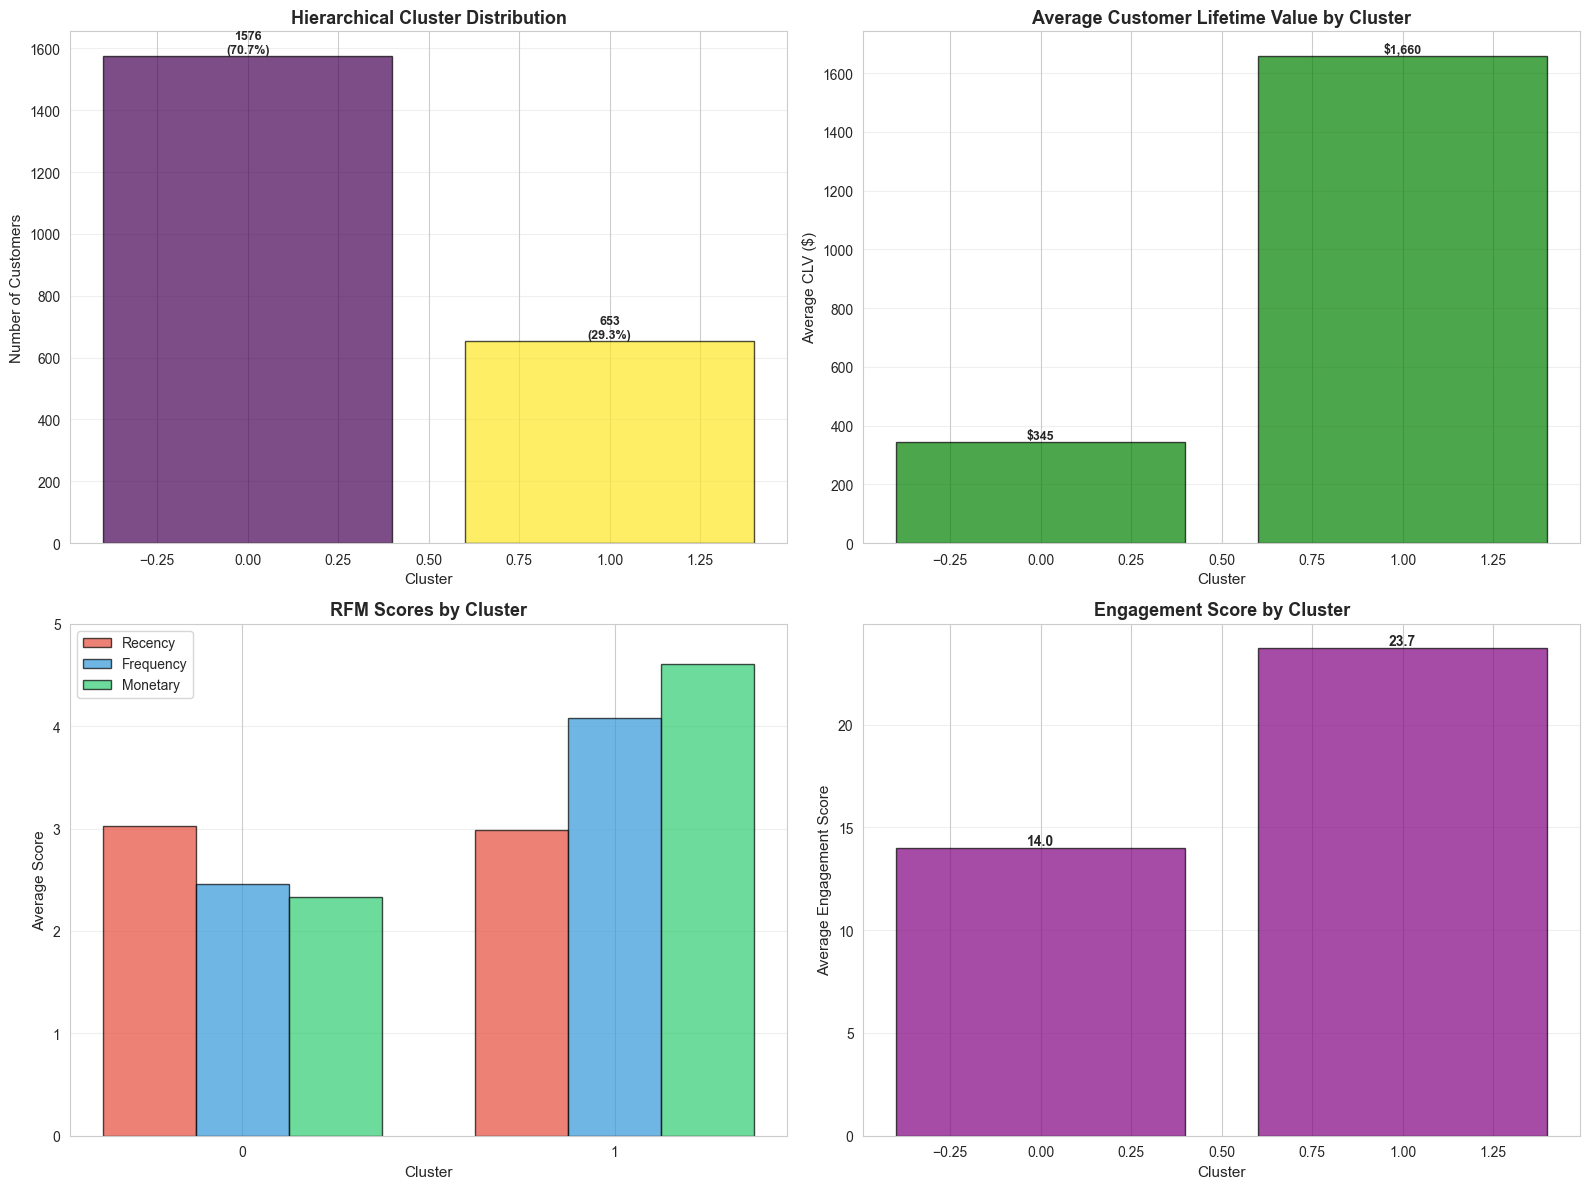


✓ Cluster characteristics visualization saved to: outputs/figures/step4_cluster_characteristics.png


In [12]:
#  Visualize Cluster Characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cluster size distribution
cluster_counts = df['Final_ML_Cluster'].value_counts().sort_index()
colors_viz = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color=colors_viz, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Cluster', fontsize=11)
axes[0, 0].set_ylabel('Number of Customers', fontsize=11)
axes[0, 0].set_title(f'{best_algo} Cluster Distribution', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(cluster_counts.values):
    pct = (v / len(df) * 100)
    axes[0, 0].text(cluster_counts.index[i], v, f'{v}\n({pct:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Average CLV by cluster
if 'CLV_Estimate' in df.columns:
    avg_clv = df.groupby('Final_ML_Cluster')['CLV_Estimate'].mean().sort_index()
    axes[0, 1].bar(avg_clv.index, avg_clv.values, color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Cluster', fontsize=11)
    axes[0, 1].set_ylabel('Average CLV ($)', fontsize=11)
    axes[0, 1].set_title('Average Customer Lifetime Value by Cluster', fontsize=13, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(avg_clv.values):
        axes[0, 1].text(avg_clv.index[i], v, f'${v:,.0f}', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)
else:
    axes[0, 1].text(0.5, 0.5, 'CLV not available', ha='center', va='center', fontsize=14)
    axes[0, 1].set_title('CLV by Cluster', fontsize=13, fontweight='bold')

# 3. RFM Scores by cluster
rfm_by_cluster = df.groupby('Final_ML_Cluster')[['R_Score', 'F_Score', 'M_Score']].mean()
x = np.arange(len(rfm_by_cluster))
width = 0.25
axes[1, 0].bar(x - width, rfm_by_cluster['R_Score'], width, label='Recency', 
              color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x, rfm_by_cluster['F_Score'], width, label='Frequency', 
              color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x + width, rfm_by_cluster['M_Score'], width, label='Monetary', 
              color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=11)
axes[1, 0].set_ylabel('Average Score', fontsize=11)
axes[1, 0].set_title('RFM Scores by Cluster', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(rfm_by_cluster.index)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 5])

# 4. Engagement Score by cluster
if 'Engagement_Score' in df.columns:
    avg_engagement = df.groupby('Final_ML_Cluster')['Engagement_Score'].mean().sort_index()
    axes[1, 1].bar(avg_engagement.index, avg_engagement.values, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Cluster', fontsize=11)
    axes[1, 1].set_ylabel('Average Engagement Score', fontsize=11)
    axes[1, 1].set_title('Engagement Score by Cluster', fontsize=13, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(avg_engagement.values):
        axes[1, 1].text(avg_engagement.index[i], v, f'{v:.1f}', 
                        ha='center', va='bottom', fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Engagement Score not available', ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Engagement Score by Cluster', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/notebooks/outputs/figures/step4_cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster characteristics visualization saved to: outputs/figures/step4_cluster_characteristics.png")

In [14]:
# Interactive Cluster Explorer Function
def explore_cluster(cluster_id, n_samples=10):
    """
    Explore a specific cluster in detail with visualizations
    """
    cluster_data = df[df['Final_ML_Cluster'] == cluster_id]
    
    print("="*80)
    print(f"CLUSTER {cluster_id} - DETAILED ANALYSIS")
    print("="*80)
    
    print(f"\n📊 Cluster Size: {len(cluster_data):,} customers ({len(cluster_data)/len(df)*100:.1f}% of total)")
    
    print(f"\n🎯 RFM Profile:")
    r_mean = cluster_data['R_Score'].mean()
    f_mean = cluster_data['F_Score'].mean()
    m_mean = cluster_data['M_Score'].mean()
    print(f"  • Recency Score: {r_mean:.2f}/5 ({'✓ Recent' if r_mean >= 3.5 else '✗ Not Recent'})")
    print(f"  • Frequency Score: {f_mean:.2f}/5 ({'✓ Frequent' if f_mean >= 3.5 else '✗ Infrequent'})")
    print(f"  • Monetary Score: {m_mean:.2f}/5 ({'✓ High Spend' if m_mean >= 3.5 else '✗ Low Spend'})")
    
    if 'CLV_Estimate' in cluster_data.columns:
        print(f"\n💰 Value Metrics:")
        print(f"  • Avg CLV: ${cluster_data['CLV_Estimate'].mean():,.2f}")
        print(f"  • Median CLV: ${cluster_data['CLV_Estimate'].median():,.2f}")
        print(f"  • Total CLV: ${cluster_data['CLV_Estimate'].sum():,.2f}")
    
    if 'Avg_Order_Value' in cluster_data.columns:
        print(f"  • Avg Order Value: ${cluster_data['Avg_Order_Value'].mean():.2f}")
    
    if 'Customer_Value_Score' in cluster_data.columns:
        print(f"  • Value Score: {cluster_data['Customer_Value_Score'].mean():.1f}/100")
    
    print(f"\n👥 Demographics:")
    print(f"  • Avg Age: {cluster_data['Age'].mean():.1f} years (range: {cluster_data['Age'].min():.0f}-{cluster_data['Age'].max():.0f})")
    print(f"  • Avg Income: ${cluster_data['Income'].mean():,.0f}")
    print(f"  • Avg Family Size: {cluster_data['Family_Size'].mean():.1f}")
    if 'Has_Children' in cluster_data.columns:
        print(f"  • Has Children: {cluster_data['Has_Children'].mean()*100:.0f}%")
    
    if 'Product_Diversity' in cluster_data.columns:
        print(f"\n🛒 Product & Channel:")
        print(f"  • Avg Product Diversity: {cluster_data['Product_Diversity'].mean():.1f} categories")
    if 'Web_Purchase_Ratio' in cluster_data.columns:
        print(f"  • Web Purchase Ratio: {cluster_data['Web_Purchase_Ratio'].mean()*100:.0f}%")
    if 'Store_Purchase_Ratio' in cluster_data.columns:
        print(f"  • Store Purchase Ratio: {cluster_data['Store_Purchase_Ratio'].mean()*100:.0f}%")
    if 'Wine_Ratio' in cluster_data.columns:
        print(f"  • Wine Buyers: {(cluster_data['Wine_Ratio'] > 0).mean()*100:.0f}%")
    if 'Premium_Product_Ratio' in cluster_data.columns:
        print(f"  • Premium Product Preference: {cluster_data['Premium_Product_Ratio'].mean()*100:.0f}%")
    
    if 'Campaign_Acceptance_Rate' in cluster_data.columns:
        print(f"\n📱 Engagement:")
        print(f"  • Campaign Response Rate: {cluster_data['Campaign_Acceptance_Rate'].mean()*100:.0f}%")
    if 'Engagement_Score' in cluster_data.columns:
        print(f"  • Engagement Score: {cluster_data['Engagement_Score'].mean():.1f}")
    if 'Is_Active' in cluster_data.columns:
        print(f"  • Active Customers: {cluster_data['Is_Active'].mean()*100:.0f}%")
    if 'NumWebVisitsMonth' in cluster_data.columns:
        print(f"  • Avg Website Visits/Month: {cluster_data['NumWebVisitsMonth'].mean():.1f}")
    
    flag_cols = ['Is_High_Spender', 'Is_Campaign_Responder', 'Is_Web_Shopper', 'Is_Deal_Seeker']
    available_flags = [f for f in flag_cols if f in cluster_data.columns]
    if available_flags:
        print(f"\n🚩 Customer Flags:")
        for flag in available_flags:
            pct = cluster_data[flag].mean() * 100
            print(f"  • {flag.replace('Is_', '').replace('_', ' ')}: {pct:.0f}%")
    
    # Most common RFM segment in this cluster
    if 'Customer_Segment' in cluster_data.columns:
        print(f"\n🏷️ Most Common RFM Segment:")
        top_segment = cluster_data['Customer_Segment'].mode()[0]
        segment_count = (cluster_data['Customer_Segment'] == top_segment).sum()
        segment_pct = (segment_count / len(cluster_data)) * 100
        print(f"  • {top_segment}: {segment_count} customers ({segment_pct:.1f}%)")
    
    print(f"\n📋 Sample Customers (first {n_samples}):")
    sample_cols = ['ID', 'Age', 'Income', 'R_Score', 'F_Score', 'M_Score']
    if 'CLV_Estimate' in cluster_data.columns:
        sample_cols.append('CLV_Estimate')
    if 'Customer_Value_Score' in cluster_data.columns:
        sample_cols.append('Customer_Value_Score')
    
    # Filter to existing columns
    sample_cols = [c for c in sample_cols if c in cluster_data.columns]
    display(cluster_data[sample_cols].head(n_samples))
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Cluster {cluster_id} - Detailed Profile', fontsize=16, fontweight='bold')
    
    # 1. RFM Bar Chart
    rfm_scores = cluster_data[['R_Score', 'F_Score', 'M_Score']].mean()
    colors_rfm = ['#e74c3c', '#3498db', '#2ecc71']
    bars = axes[0, 0].bar(rfm_scores.index, rfm_scores.values, color=colors_rfm, alpha=0.7, edgecolor='black')
    axes[0, 0].set_ylabel('Average Score')
    axes[0, 0].set_title('RFM Profile', fontweight='bold')
    axes[0, 0].set_ylim([0, 5])
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].axhline(y=3.5, color='orange', linestyle='--', alpha=0.5, label='Good threshold')
    axes[0, 0].legend()
    for bar, v in zip(bars, rfm_scores.values):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, v, f'{v:.2f}', 
                       ha='center', va='bottom', fontweight='bold')
    
    # 2. Age Distribution
    axes[0, 1].hist(cluster_data['Age'], bins=20, color='purple', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(cluster_data['Age'].mean(), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {cluster_data["Age"].mean():.0f}')
    axes[0, 1].set_xlabel('Age (years)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Age Distribution', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. CLV or Income Distribution
    if 'CLV_Estimate' in cluster_data.columns:
        axes[1, 0].hist(cluster_data['CLV_Estimate'], bins=20, color='green', alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(cluster_data['CLV_Estimate'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                          label=f'Mean: ${cluster_data["CLV_Estimate"].mean():,.0f}')
        axes[1, 0].set_xlabel('CLV ($)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Customer Lifetime Value Distribution', fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
    else:
        axes[1, 0].hist(cluster_data['Income'], bins=20, color='gold', alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Income ($)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Income Distribution', fontweight='bold')
        axes[1, 0].grid(alpha=0.3)
    
    # 4. Product Diversity or Value Score
    if 'Product_Diversity' in cluster_data.columns:
        diversity_counts = cluster_data['Product_Diversity'].value_counts().sort_index()
        axes[1, 1].bar(diversity_counts.index, diversity_counts.values, color='teal', alpha=0.7, edgecolor='black')
        axes[1, 1].set_xlabel('Number of Product Categories')
        axes[1, 1].set_ylabel('Number of Customers')
        axes[1, 1].set_title('Product Diversity', fontweight='bold')
        axes[1, 1].grid(axis='y', alpha=0.3)
        # Add percentages on bars
        for i, v in enumerate(diversity_counts.values):
            pct = (v / len(cluster_data)) * 100
            axes[1, 1].text(diversity_counts.index[i], v, f'{v}\n({pct:.0f}%)', 
                           ha='center', va='bottom', fontsize=9)
    elif 'Customer_Value_Score' in cluster_data.columns:
        axes[1, 1].hist(cluster_data['Customer_Value_Score'], bins=20, color='coral', alpha=0.7, edgecolor='black')
        axes[1, 1].set_xlabel('Value Score (0-100)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Customer Value Score Distribution', fontweight='bold')
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)



CLUSTER 0 - DETAILED ANALYSIS

📊 Cluster Size: 1,576 customers (70.7% of total)

🎯 RFM Profile:
  • Recency Score: 3.03/5 (✗ Not Recent)
  • Frequency Score: 2.46/5 (✗ Infrequent)
  • Monetary Score: 2.33/5 (✗ Low Spend)

💰 Value Metrics:
  • Avg CLV: $345.18
  • Median CLV: $151.02
  • Total CLV: $544,007.90
  • Avg Order Value: $16.76
  • Value Score: 40.1/100

👥 Demographics:
  • Avg Age: 54.6 years (range: 28-84)
  • Avg Income: $42,425
  • Avg Family Size: 2.9
  • Has Children: 91%

🛒 Product & Channel:
  • Avg Product Diversity: 5.3 categories
  • Web Purchase Ratio: 25%
  • Store Purchase Ratio: 37%
  • Wine Buyers: 99%
  • Premium Product Preference: 74%

📱 Engagement:
  • Campaign Response Rate: 3%
  • Engagement Score: 14.0
  • Active Customers: 91%
  • Avg Website Visits/Month: 6.1

🚩 Customer Flags:
  • High Spender: 2%
  • Campaign Responder: 16%
  • Web Shopper: 0%
  • Deal Seeker: 12%

🏷️ Most Common RFM Segment:
  • Potential Loyalists: 271 customers (17.2%)

📋 Sample C

,ID,Age,Income,R_Score,F_Score,M_Score,CLV_Estimate,Customer_Value_Score
1,2174,70,46344.0,4,1,1,23.142857,25.000000
3,6182,40,26646.0,4,2,1,47.111111,33.333333
4,5324,43,58293.0,1,4,3,400.900000,41.666667
5,7446,57,62513.0,5,4,4,684.869565,83.333333
6,965,53,55635.0,4,4,3,914.977584,66.666667


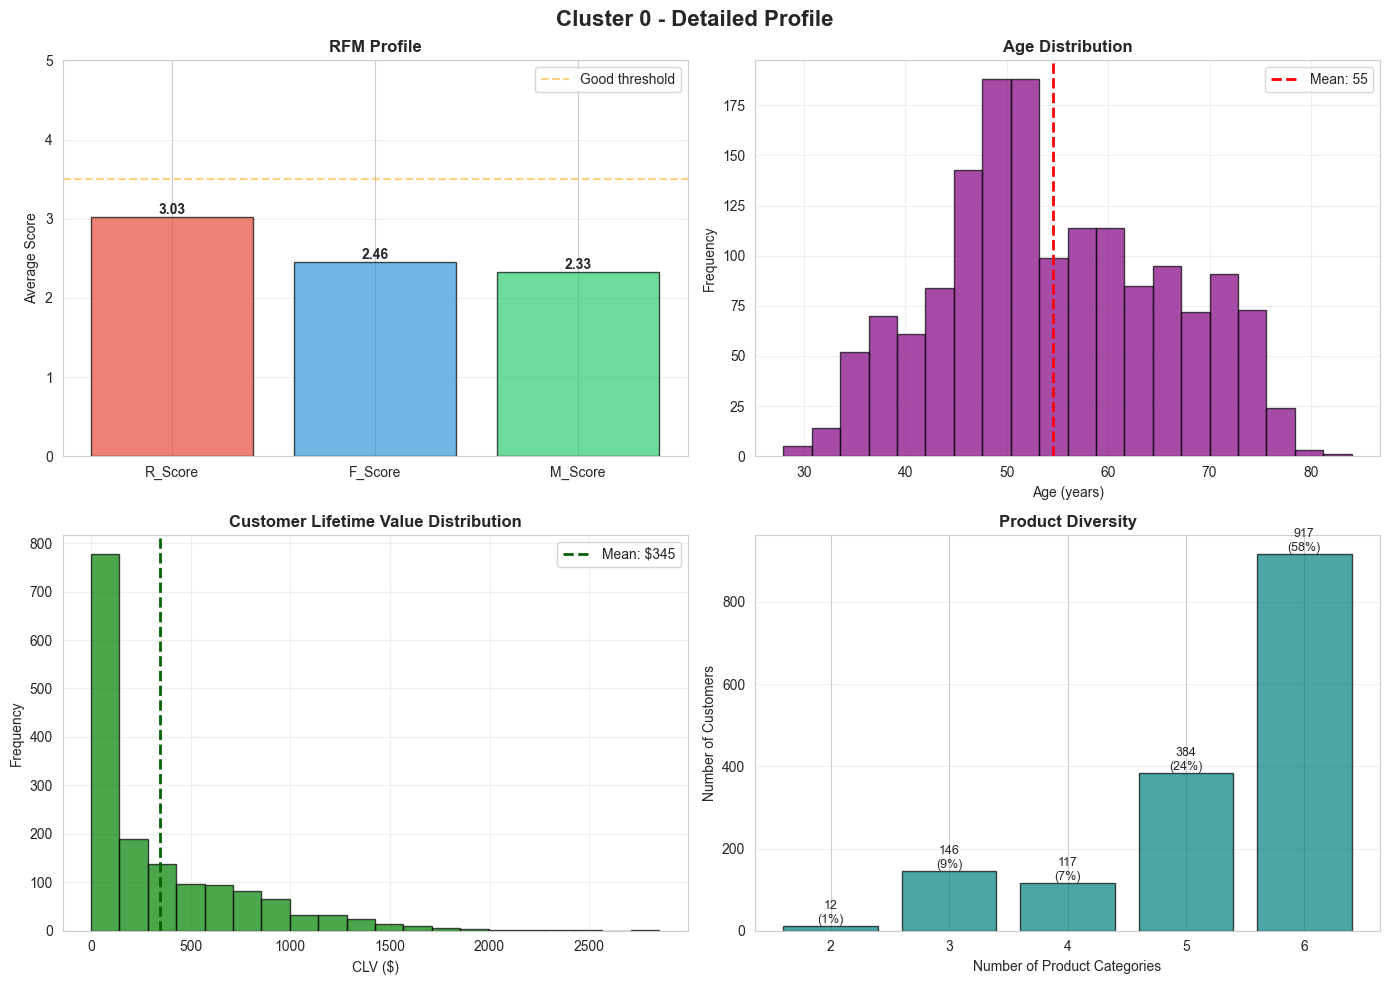

In [15]:
explore_cluster(0, n_samples=5)

CLUSTER 1 - DETAILED ANALYSIS

📊 Cluster Size: 653 customers (29.3% of total)

🎯 RFM Profile:
  • Recency Score: 2.98/5 (✗ Not Recent)
  • Frequency Score: 4.08/5 (✓ Frequent)
  • Monetary Score: 4.60/5 (✓ High Spend)

💰 Value Metrics:
  • Avg CLV: $1,659.61
  • Median CLV: $1,554.38
  • Total CLV: $1,083,723.60
  • Avg Order Value: $65.11
  • Value Score: 72.3/100

👥 Demographics:
  • Avg Age: 56.4 years (range: 29-83)
  • Avg Income: $73,810
  • Avg Family Size: 1.9
  • Has Children: 26%

🛒 Product & Channel:
  • Avg Product Diversity: 5.7 categories
  • Web Purchase Ratio: 25%
  • Store Purchase Ratio: 38%
  • Wine Buyers: 100%
  • Premium Product Preference: 85%

📱 Engagement:
  • Campaign Response Rate: 17%
  • Engagement Score: 23.7
  • Active Customers: 92%
  • Avg Website Visits/Month: 3.4

🚩 Customer Flags:
  • High Spender: 81%
  • Campaign Responder: 53%
  • Web Shopper: 0%
  • Deal Seeker: 0%

🏷️ Most Common RFM Segment:
  • Champions: 182 customers (27.9%)

📋 Sample Custom

,ID,Age,Income,R_Score,F_Score,M_Score,CLV_Estimate,Customer_Value_Score
0,5524,67,58138.0,3,5,5,2824.212329,83.333333
2,4141,59,71613.0,4,4,4,740.727273,75.000000
12,2125,65,63033.0,1,3,4,1037.176471,41.666667
15,2114,78,82800.0,4,5,5,2019.135464,91.666667
18,6565,75,76995.0,1,5,5,2153.227397,66.666667


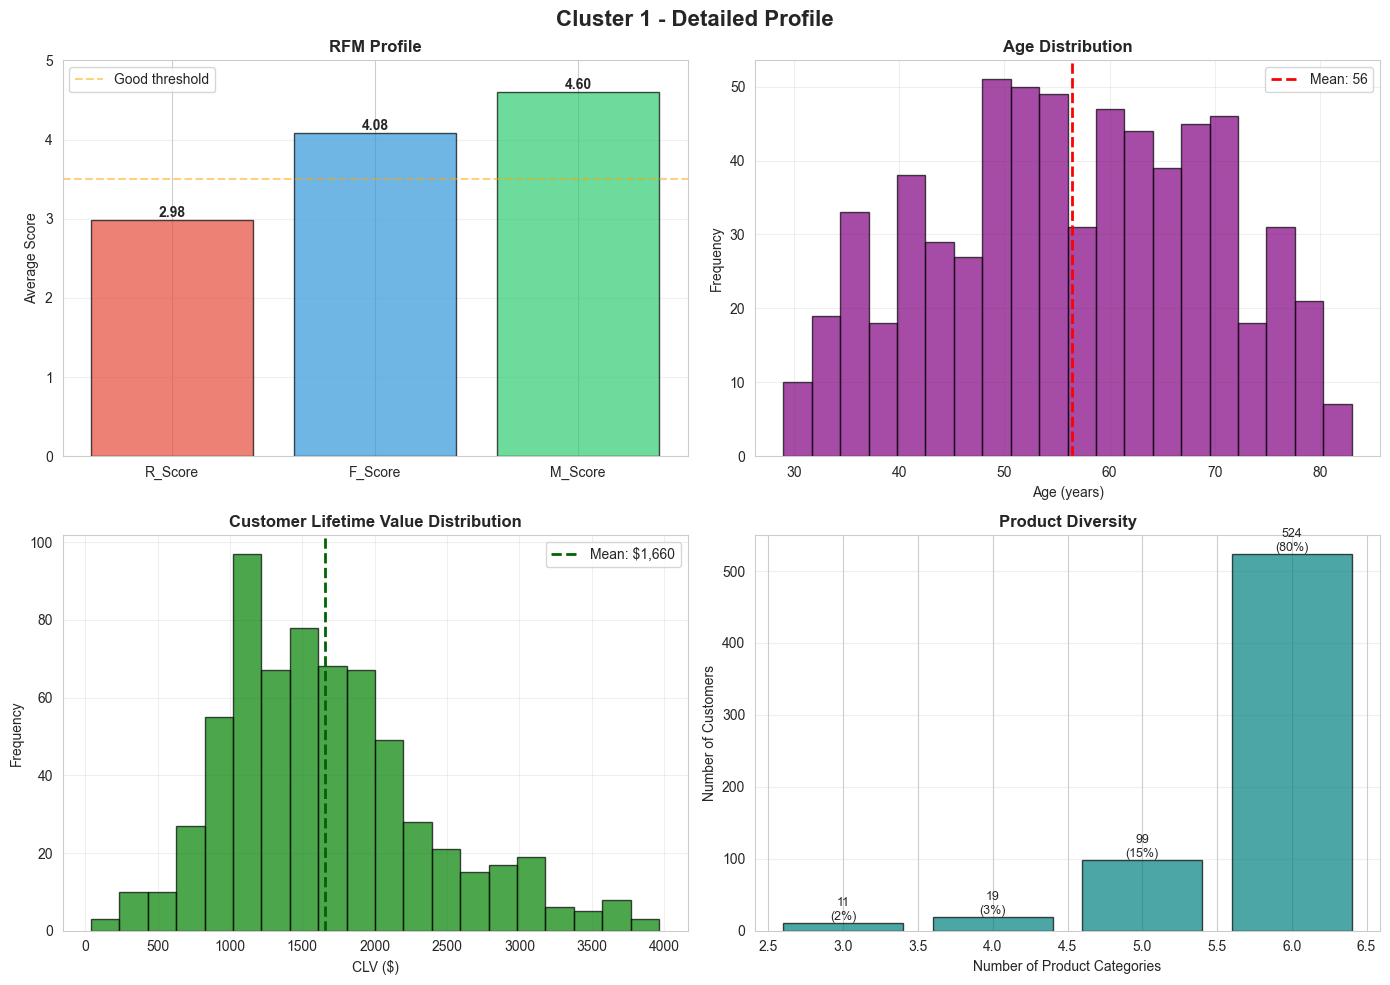

In [16]:
explore_cluster(1, n_samples=5)

In [17]:
# Save Clustered Data
df.to_csv('D://My projects/customer_segmentation_project/data/processed/step4_clustered_customers.csv', index=False)
print("\n✓ Clustered customer data saved to: outputs/data/step4_clustered_customers.csv")



✓ Clustered customer data saved to: outputs/data/step4_clustered_customers.csv
